# Plot fig. 7.6

In [8]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.gridspec as gridspec
import pandas as pd
from matplotlib import rc
from netCDF4 import Dataset
import scipy.stats as st
import warnings

In [2]:
pl.rcParams['figure.figsize'] = (18/2.54, 11/2.54)
pl.rcParams['font.size'] = 11
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.major.left'] = True
pl.rcParams['ytick.major.size'] = 0
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 150

In [ ]:
expts = {
    3: r'10$\times$BC',
    1: r'3$\times$CH$_4$',
    0: r'2$\times$CO$_2$',
    2: '+2%Sol',
    4: r'5$\times$Sul',
    5: r'9$\times$CFC-12',
    6: r'8$\times$CFC-11',
    7: r'3$\times$N$_2$O',
    8: r'5$\times$O$_3$',
    9: 'Volcanic (Pinatubo)'
}

# 10 models, 4 kernels, 10 experiments and 7 adjustments
# do adjust[model, kernel, exp]
n_mod = 10; n_ker = 6; n_exp=10

flux = {}
flux_u90 = {}
valid_count = {}

## Smith et al. 2018

In [3]:
indirs = ['../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ryan_kramer/', 
          '../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ryan_kramer/', 
          '../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ryan_kramer/', 
          '../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ryan_kramer/', 
          '../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ryan_kramer/', 
          '../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ECMWF-Oslo_gunnar_myhre/']
models = ['CanESM2', 'GISS-E2-R', 'HadGEM2', 'HadGEM3', 'IPSL-CM5A', 'MIROC-SPRINTARS', 'MPI-ESM', 'NCAR-CESM1-CAM4', 'NCAR-CESM1-CAM5', 'NorESM1']
kernels = ['HadGEM2', 'GFDL', 'BMRC', 'CCSM4', 'CESM', 'Oslo']
vars = ['ERF_SW','IRF_SW','tas_SW','ta_trop_SW','ta_strat_SW','hus_SW','alb_SW','cloud_SW','ERF_LW','IRF_LW','tas_LW','ta_trop_LW','ta_strat_LW','hus_LW','alb_LW','cloud_LW']

for var in vars:
    flux[var] = np.ones((n_mod, n_ker, n_exp)) * np.nan
    flux_u90[var] = np.ones((n_mod, n_ker, n_exp)) * np.nan
    for i_mod,model in enumerate(models):
        for i_ker,kernel in enumerate(kernels):
            nc = Dataset(indirs[i_ker]+'%s_K%s_LWSW_TOA.nc' % (model, kernel))
            flux[var][i_mod,i_ker,:]    = nc.variables[var][:]
            nc.close()
            
# replace MPI 10xBC with ECHAM.
for var in vars:
    for i_ker,kernel in enumerate(kernels[:]):
        nc = Dataset(indirs[i_ker]+'ECHAM-HAM_K%s_LWSW_TOA.nc' % kernel)
        flux[var][6,i_ker,3]    = nc.variables[var][3]
        nc.close()

# Remove SO4 clouds and IRF from Ryan for all except CAM4 as they are not correct (in GISS) or contain some component of IRF (in SPRINTARS or HadGEM2)
flux['cloud_SW'][0:7,:5,4] = np.nan
flux['cloud_LW'][0:7,:5,4] = np.nan
flux['cloud_SW'][8:10,:5,4] = np.nan
flux['cloud_LW'][8:10,:5,4] = np.nan

flux['IRF_SW'][0:7,:5,4] = np.nan
flux['IRF_LW'][0:7,:5,4] = np.nan
flux['IRF_SW'][8:10,:5,4] = np.nan
flux['IRF_LW'][8:10,:5,4] = np.nan

# Remove MPI SO4 and BC from Gunnar
for var in vars:
    flux[var][6,5,4] = np.nan
    flux[var][6,5,4] = np.nan
    valid_count[var] = np.count_nonzero(~np.isnan(flux[var][:]), axis=(0,1))

# Remove CAM5 clouds from Gunnar
flux['cloud_SW'][8,5,:] = np.nan
flux['cloud_LW'][8,5,:] = np.nan

## Hodnebrog et al 2020

In [13]:
df_hod = pd.read_csv('../data_input/Hodnebrog_et_al_2020_adjustments.csv')

df_hod[df_hod['Experiment']=='CFC11x8']['Ttrop']
df_hod[df_hod['Experiment']=='CFC11x8']['Tstrat']
df_hod[df_hod['Experiment']=='CFC11x8']['WV']
df_hod[df_hod['Experiment']=='CFC11x8']['alpha']
df_hod[df_hod['Experiment']=='CFC11x8']['Coulds']

,Experiment,Model,IRF,Ts,Ttrop,Tstrat,WV,alpha,Clouds,RA,ERF
0,CFC11x8,ECHAM-HAM,1.13,-0.0771,-0.1090,-0.0537,0.1380,0.016000,0.2540,0.16800,1.29
1,CFC11x8,HadGEM2,1.23,-0.0656,-0.2740,-0.0342,0.2590,0.000187,0.0807,-0.03400,1.20
2,CFC11x8,MIROC-SPRINTARS,1.15,-0.0410,-0.1220,-0.0774,0.1070,0.008430,0.1260,0.00101,1.15
3,CFC11x8,NCAR-CESM1-CAM4,1.17,-0.0362,-0.0374,-0.0345,0.0927,0.003190,0.1290,0.11700,1.29


In [4]:
warnings.simplefilter('ignore')
flux_avK = {}
flux_avMK = {}

for var in vars:
    flux_avK[var] = np.nanmean(flux[var][:], axis=1)
    flux_avMK[var] = np.nanmean(flux_avK[var][:], axis=0)
    valid_count[var] = np.count_nonzero(~np.isnan(flux[var][:]), axis=(0,1))

tas = flux_avMK['tas_SW'] + flux_avMK['tas_LW']
ta_trop = flux_avMK['ta_trop_SW'] + flux_avMK['ta_trop_LW']
ta_strat = flux_avMK['ta_strat_SW'] + flux_avMK['ta_strat_LW']
hus = flux_avMK['hus_SW'] + flux_avMK['hus_LW']
alb = flux_avMK['alb_SW'] + flux_avMK['alb_LW']
cloud = flux_avMK['cloud_SW'] + flux_avMK['cloud_LW']
ERF = flux_avMK['ERF_SW'] + flux_avMK['ERF_LW'] - tas
RA = ta_trop+ta_strat+hus+alb+cloud
IRF = ERF-RA

u90_ERF = np.nanstd(flux_avK['ERF_LW']+flux_avK['ERF_SW']-flux_avK['tas_LW']-flux_avK['tas_SW'], ddof=0, axis=0) * 1.645 #st.t.ppf(0.95, valid_count['ERF_LW']-1)
u90_tas = np.nanstd(flux_avK['tas_LW']+flux_avK['tas_SW'], ddof=0, axis=0) * 1.645 #* st.t.ppf(0.95, valid_count['tas_LW']-1)
u90_ta_trop = np.nanstd(flux_avK['ta_trop_LW']+flux_avK['ta_trop_SW'], ddof=0, axis=0) * 1.645 #* st.t.ppf(0.95, valid_count['ta_trop_LW']-1)
u90_ta_strat = np.nanstd(flux_avK['ta_strat_LW']+flux_avK['ta_strat_SW'], ddof=0, axis=0) * 1.645 #* st.t.ppf(0.95, valid_count['ta_strat_LW']-1)
u90_hus = np.nanstd(flux_avK['hus_LW']+flux_avK['hus_SW'], ddof=0, axis=0) * 1.645 #* st.t.ppf(0.95, valid_count['hus_LW']-1)
u90_alb = np.nanstd(flux_avK['alb_LW']+flux_avK['alb_SW'], ddof=0, axis=0) * 1.645 #* st.t.ppf(0.95, valid_count['alb_SW']-1)
u90_cloud = np.nanstd(flux_avK['cloud_LW']+flux_avK['cloud_SW'], ddof=0, axis=0) * 1.645 #* st.t.ppf(0.95, valid_count['cloud_LW']-1)
u90_RA = np.nanstd(flux_avK['tas_LW']+flux_avK['tas_SW']+flux_avK['ta_trop_LW']+flux_avK['ta_trop_SW']+
               flux_avK['ta_strat_LW']+flux_avK['ta_strat_SW']+flux_avK['hus_LW']+flux_avK['hus_SW']+
               flux_avK['alb_LW']+flux_avK['alb_SW']+flux_avK['cloud_LW']+flux_avK['cloud_SW'], ddof=0, axis=0) * 1.645 #* st.t.ppf(0.95, valid_count['cloud_LW']-1)
u90_IRF = np.nanstd(flux_avK['ERF_LW']+flux_avK['ERF_SW']-flux_avK['tas_LW']-flux_avK['tas_SW']-
                (flux_avK['tas_LW']+flux_avK['tas_SW']+flux_avK['ta_trop_LW']+flux_avK['ta_trop_SW']+
               flux_avK['ta_strat_LW']+flux_avK['ta_strat_SW']+flux_avK['hus_LW']+flux_avK['hus_SW']+
               flux_avK['alb_LW']+flux_avK['alb_SW']+flux_avK['cloud_LW']+flux_avK['cloud_SW']), ddof=0, axis=0) * 1.645 #* st.t.ppf(0.95, valid_count['cloud_LW']-1)

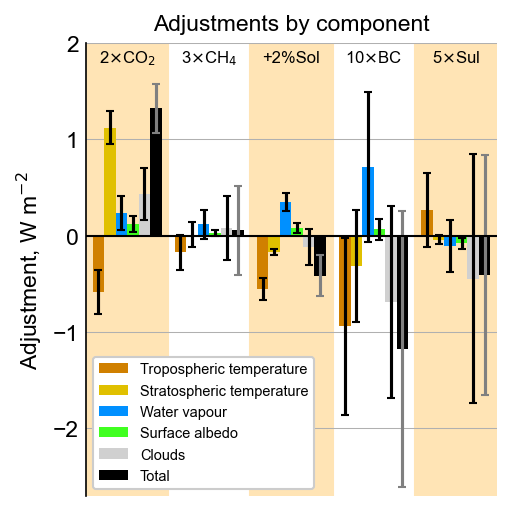

In [5]:
pl.rcParams['figure.figsize'] = (9/2.54, 9/2.54)
gs = gridspec.GridSpec(1,1)
ax1 = pl.subplot(gs[0,0])

colors = ['slateblue', 'indigo', 'black', 'dimgray']
labels = ['Instantaneous radiative forcing',
          'Effective radiative forcing',
          'Adjustment',
          'Residual']


colors = ['#a03800','#d08000','#e0c000','#0090ff','#40ff20','#d0d0d0','black']
labels = ['Surface temperature','Tropospheric temperature','Stratospheric temperature','Water vapour','Surface albedo','Clouds','Total']
for a in range(1,5):
    ax1.bar(0.15+a, ta_trop[a], 0.14, color=colors[1], yerr=u90_ta_trop[a], capsize=2, zorder=3)
    ax1.bar(0.29+a, ta_strat[a], 0.14, color=colors[2], yerr=u90_ta_strat[a], capsize=2, zorder=3)
    ax1.bar(0.43+a, hus[a], 0.14, color=colors[3], yerr=u90_hus[a], capsize=2, zorder=3)
    ax1.bar(0.57+a, alb[a], 0.14, color=colors[4], yerr=u90_alb[a], capsize=2, zorder=3)
    ax1.bar(0.71+a, cloud[a], 0.14, color=colors[5], yerr=u90_cloud[a], capsize=2, zorder=3)
    ax1.bar(0.85+a, RA[a], 0.14, color=colors[6], yerr=u90_RA[a], ecolor='gray', capsize=2, zorder=3)
    ax1.text(0.5+a,1.8,expts[a], ha='center' , fontsize=8)
a=0
ax1.bar(0.15+a, ta_trop[a], 0.14, color=colors[1], label=labels[1], yerr=u90_ta_trop[a], capsize=2, zorder=3)
ax1.bar(0.29+a, ta_strat[a], 0.14, color=colors[2], label=labels[2], yerr=u90_ta_strat[a], capsize=2, zorder=3)
ax1.bar(0.43+a, hus[a], 0.14, color=colors[3], label=labels[3], yerr=u90_hus[a], capsize=2, zorder=3)
ax1.bar(0.57+a, alb[a], 0.14, color=colors[4], label=labels[4], yerr=u90_alb[a], capsize=2, zorder=3)
ax1.bar(0.71+a, cloud[a], 0.14, color=colors[5], label=labels[5], yerr=u90_cloud[a], capsize=2, zorder=3)
ax1.bar(0.85+a, RA[a], 0.14, color=colors[6], label=labels[6], yerr=u90_RA[a], ecolor='gray', capsize=2, zorder=3)

ax1.text(0.5+a,1.8,expts[a], ha='center', fontsize=8)

ax1.set_ylabel('Adjustment, W m$^{-2}$')

ax1.axhline(0, color='k', lw=1, zorder=4)

ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.xaxis.set_visible(False)

mn,mx = ax1.get_ylim()
backfill = [0,1,1,2,2,3,3,4,4,5]
fillind  = [1,1,0,0,1,1,0,0,1,1]
ax1.fill_between(backfill, -4, 5.6, where=fillind, color='moccasin', zorder=0.6)
ax1.legend(loc='lower left', framealpha=1, fontsize=7, ncol=1)#, bbox_to_anchor=[0.46,1])
ax1.set_ylim(-2.7,2)
ax1.set_xlim(0,5)
ax1.grid(axis='y', zorder=-11, lw=0.5)

ax1.set_title('Adjustments by component', fontsize=11)

pl.tight_layout()

pl.savefig('../figures/fig7.6.png')
pl.savefig('../figures/fig7.6.pdf')

In [6]:
np.nanstd(flux_avK['ERF_LW'],axis=0)

array([0.47295976, 0.13653773, 0.152923  , 0.56374997, 0.49332245])